In [13]:
import os
import datetime
# from netCDF4 import Dataset
import numpy as np
import pandas as pd
import xarray as xr
from scipy import signal, integrate, stats

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib
from matplotlib.colors import BoundaryNorm, LogNorm
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.mplot3d import Axes3D, axes3d

import cmaps, plt_helper
# import subroutines
# import vis_eulag

plt.style.use('latex_default.mplstyle')

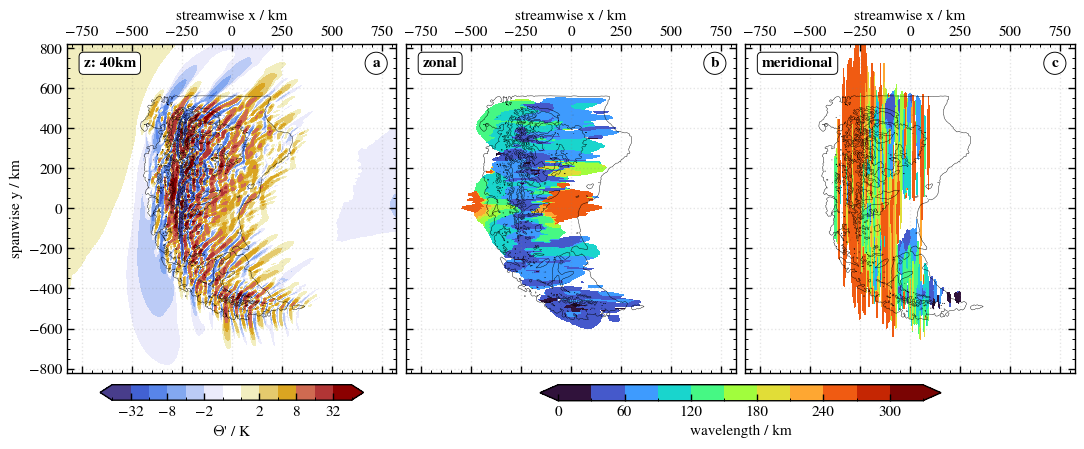

In [99]:
# folder = "/work/bd0620/b309199"
folder = "/scratch/b/b309199"
# simulation = "pata_comp_idtopo2"
simulation = "pata_comp_retopo2"
fpath = os.path.join(folder, simulation)
ds, ds_env, ds_xzslices, ds_yzslices, ds_xyslices, ds_lidars, ds_full = plt_helper.preprocess_eulag_output(fpath)
dsxy = ds_xyslices[0]
t = 100
data = dsxy["th"][t,:,:].values
xlim  = [ds.xcr.min().values+ds.dxabL/1000,ds.xcr.max().values-ds.dxabR/1000]
ylim  = [ds.ycr.min().values+ds.dyab/1000,ds.ycr.max().values-ds.dyab/1000]

surf_factor = 5
cutoffx = 200*1000
cmap   = cmaps.get_wave_cmap()
clev, clev_l = plt_helper.get_colormap_bins_and_labels(max_level=64)
norm = BoundaryNorm(boundaries=clev , ncolors=cmap.N, clip=True)

cmap_wl = plt.get_cmap('turbo')
clev_wl = np.arange(0,360,30)
norm_wl = BoundaryNorm(boundaries=clev_wl, ncolors=cmap_wl.N, clip=True)

lambdax = plt_helper.wavelet_1D_decomp(data, ds.dx00/1000, dim=0)
lambday = plt_helper.wavelet_1D_decomp(data, ds.dx00/1000, dim=1)

ep  = 1/2*dsxy['rh0'][t,:,:]*(ds.g/ds.bv)**2 * (dsxy['th'][t,:,:]/dsxy['the'][t,:,:])**2
mfx = dsxy['rh0'][t,:,:] * dsxy['w'][t,:,:] * (dsxy['u'][t,:,:]-dsxy['ue'][t,:,:]) 
mfx = plt_helper.gaussian_filter_fft(mfx, cutoffx, cutoffx, ds.dy00, ds.dx00)
ep  = plt_helper.gaussian_filter_fft(ep , cutoffx, cutoffx, ds.dy00, ds.dx00)
# ep  = subroutines.fft_gaussian_xy(ep,nx_avg,ny_avg=None)
# mfx_obs = 2 * ep * lambdaz/(-lambdax)

"""Figure stuff"""
gskw  = {'hspace':0.05, 'wspace':0.03, 'height_ratios': [8,1], 'width_ratios': [1,1,1]} 
fig, axes = plt.subplots(2,3, sharex=True, sharey=True, figsize=(13,5), gridspec_kw=gskw)

ax0 = axes[0,0]
ax1 = axes[0,1]
ax2 = axes[0,2]
for ax in axes[-1,0:3]:
    ax.set_axis_off()

ax0.set_aspect("equal")
ax1.set_aspect("equal")
ax2.set_aspect("equal")
contf_th = ax0.contourf(ds.xcr, ds.ycr, data, cmap=cmap, norm=norm, levels=clev, extend='both')
contf_wl = ax1.contourf(ds.xcr, ds.ycr, lambdax, cmap=cmap_wl, norm=norm_wl, levels=clev_wl, extend='both')
contf_wl = ax2.contourf(ds.xcr, ds.ycr, lambday, cmap=cmap_wl, norm=norm_wl, levels=clev_wl, extend='both')

### - Topography - ###
if ds.itopo == 1:
    amp = dsxy.zcrtopo.max()
    amp = 1200
    topo_levels=np.linspace(20,surf_factor*amp,3)
else:
    if ds.amp < 0:
        topo_levels=np.linspace(surf_factor*ds.amp,-surf_factor*ds.amp,12)
    else: 
        topo_levels=np.linspace(-2*surf_factor*ds.amp,2*surf_factor*ds.amp,24)
ctopo = "k"
lwtopo = 0.3
ax0.contour(ds.xcr, ds.ycr, surf_factor*dsxy.zcrtopo[t,:,:], colors=ctopo, levels=topo_levels, linewidths=lwtopo)
ax1.contour(ds.xcr, ds.ycr, surf_factor*dsxy.zcrtopo[t,:,:], colors=ctopo, levels=topo_levels, linewidths=lwtopo)
ax2.contour(ds.xcr, ds.ycr, surf_factor*dsxy.zcrtopo[t,:,:], colors=ctopo, levels=topo_levels, linewidths=lwtopo)

numstr = ['a','b','c']
for ip, ax in enumerate(axes[0,0:3]):
    ax.text(0.95, 0.93, numstr[ip], transform=ax.transAxes, horizontalalignment='right', weight='bold', bbox={"boxstyle" : "circle", "lw":0.67, "facecolor":"white", "edgecolor":"black"})
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='both', labeltop=True)
    ax.xaxis.set_label_position('top')
    ax.set_xlabel('streamwise x / km')
    ax.grid()
    
ax0.text(0.05, 0.93, "z: " + str(int(dsxy.zpos)) + "km", transform=ax0.transAxes, weight='bold', bbox={"boxstyle" : "round", "lw":0.67, "facecolor":"white", "edgecolor":"black"})
ax1.text(0.05, 0.93, "zonal", transform=ax1.transAxes, weight='bold', bbox={"boxstyle" : "round", "lw":0.67, "facecolor":"white", "edgecolor":"black"})
ax2.text(0.05, 0.93, "meridional", transform=ax2.transAxes, weight='bold', bbox={"boxstyle" : "round", "lw":0.67, "facecolor":"white", "edgecolor":"black"})

ax0.set_xlim(xlim)
ax0.set_ylim(ylim)
ax0.set_ylabel('spanwise y / km')

cbar = fig.colorbar(contf_th, ax=axes[-1,0], orientation='horizontal', ticks=clev_l, shrink=0.8, fraction=1,aspect=17) # anchor=(0,0)
cbar.set_label(r"$\Theta$' / K")
cbar = fig.colorbar(contf_wl, ax=axes[-1,1:3], orientation='horizontal', shrink=0.6, fraction=1, aspect=25)
cbar.set_label('wavelength / km')

fig_title = simulation + "_wavelet_z" + str(int(dsxy.zpos)) + ".png"
imagefolder = "../data/wavelet"
fig.savefig(os.path.join(imagefolder,fig_title), facecolor='w', edgecolor='w',
            format='png', dpi=120, bbox_inches='tight')

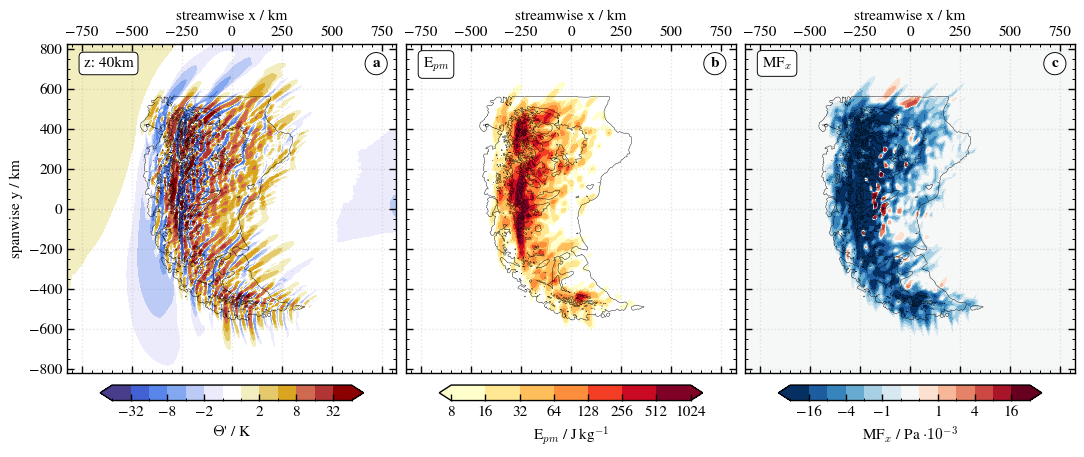

In [102]:
"""Potential energy / Momentum flux"""
# folder = "/work/bd0620/b309199"
folder = "/scratch/b/b309199"
# simulation = "pata_comp_idtopo2"
simulation = "pata_comp_retopo2"
fpath = os.path.join(folder, simulation)
ds, ds_env, ds_xzslices, ds_yzslices, ds_xyslices, ds_lidars, ds_full = plt_helper.preprocess_eulag_output(fpath)

level = 0
if level == 0:
    dsxy = ds_xyslices[level]
    cbar_mf_label = r"MF$_x$ / Pa $\cdot 10^{-3}$"
else:
    dsxy = ds_xyslices[level]
    cbar_mf_label = r"MF$_x$ / Pa $\cdot 10^{-6}$"
cutoffx = 300*1000

t = 100
data = dsxy["th"][t,:,:].values
xlim  = [ds.xcr.min().values+ds.dxabL/1000,ds.xcr.max().values-ds.dxabR/1000]
ylim  = [ds.ycr.min().values+ds.dyab/1000,ds.ycr.max().values-ds.dyab/1000]

surf_factor = 5
cmap   = cmaps.get_wave_cmap()
clev, clev_l = plt_helper.get_colormap_bins_and_labels(max_level=64)
norm = BoundaryNorm(boundaries=clev , ncolors=cmap.N, clip=True)

cmap_ep = plt.get_cmap('YlOrRd')
clev_ep, clev_l_ep = plt_helper.get_colormap_bins_and_labels(max_level=32)
# clev_ep = np.arange(50,500,50)
clev_ep = [8,16,32,64,128,256,512,1024]
norm_ep = BoundaryNorm(boundaries=clev_ep, ncolors=cmap_ep.N, clip=True)

cmap_mf = plt.get_cmap('RdBu_r')
clev_mf, clev_l_mf = plt_helper.get_colormap_bins_and_labels(max_level=32)
norm_mf = BoundaryNorm(boundaries=clev_mf, ncolors=cmap_mf.N, clip=True)

# lambdax = plt_helper.wavelet_1D_decomp(data, ds.dx00/1000, dim=0)
# lambday = plt_helper.wavelet_1D_decomp(data, ds.dx00/1000, dim=1)

epm = 1/2*(ds.g/ds.bv)**2 * (dsxy['th'][t,:,:]/dsxy['the'][t,:,:])**2
epv = dsxy['rh0'][t,:,:]*epm
mfx = dsxy['rh0'][t,:,:] * dsxy['w'][t,:,:] * (dsxy['u'][t,:,:]-dsxy['ue'][t,:,:]) 
mfx = plt_helper.gaussian_filter_fft(mfx, cutoffx, cutoffx, ds.dy00, ds.dx00)
epm = plt_helper.gaussian_filter_fft(epm, cutoffx, cutoffx, ds.dy00, ds.dx00)
epm = np.where(epm>clev_ep[0],epm,np.nan)
if level == 0:
    mfx = mfx * 10**3
else:
    mfx = mfx * 10**6
# ep  = subroutines.fft_gaussian_xy(ep,nx_avg,ny_avg=None)
# mfx_obs = 2 * ep * lambdaz/(-lambdax)

"""Figure stuff"""
gskw  = {'hspace':0.05, 'wspace':0.03, 'height_ratios': [8,1], 'width_ratios': [1,1,1]} 
fig, axes = plt.subplots(2,3, sharex=True, sharey=True, figsize=(13,5), gridspec_kw=gskw)

ax0 = axes[0,0]
ax1 = axes[0,1]
ax2 = axes[0,2]
for ax in axes[-1,0:3]:
    ax.set_axis_off()

ax0.set_aspect("equal")
ax1.set_aspect("equal")
ax2.set_aspect("equal")
contf_th = ax0.contourf(ds.xcr, ds.ycr, data, cmap=cmap, norm=norm, levels=clev, extend='both')
contf_ep = ax1.contourf(ds.xcr, ds.ycr, epm, cmap=cmap_ep, norm=norm_ep, levels=clev_ep, extend='both')
contf_mf = ax2.contourf(ds.xcr, ds.ycr, mfx, cmap=cmap_mf, norm=norm_mf, levels=clev_mf, extend='both')

### - Topography - ###
if ds.itopo == 1:
    amp = dsxy.zcrtopo.max()
    amp = 1200
    topo_levels=np.linspace(20,surf_factor*amp,3)
else:
    if ds.amp < 0:
        topo_levels=np.linspace(surf_factor*ds.amp,-surf_factor*ds.amp,12)
    else: 
        topo_levels=np.linspace(-2*surf_factor*ds.amp,2*surf_factor*ds.amp,24)
ctopo = "k"
lwtopo = 0.3
ax0.contour(ds.xcr, ds.ycr, surf_factor*dsxy.zcrtopo[t,:,:], colors=ctopo, levels=topo_levels, linewidths=lwtopo)
ax1.contour(ds.xcr, ds.ycr, surf_factor*dsxy.zcrtopo[t,:,:], colors=ctopo, levels=topo_levels, linewidths=lwtopo)
ax2.contour(ds.xcr, ds.ycr, surf_factor*dsxy.zcrtopo[t,:,:], colors=ctopo, levels=topo_levels, linewidths=lwtopo)

numstr = ['a','b','c']
for ip, ax in enumerate(axes[0,0:3]):
    ax.text(0.95, 0.93, numstr[ip], transform=ax.transAxes, horizontalalignment='right', weight='bold', bbox={"boxstyle" : "circle", "lw":0.67, "facecolor":"white", "edgecolor":"black"})
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='both', labeltop=True)
    ax.xaxis.set_label_position('top')
    ax.set_xlabel('streamwise x / km')
    ax.grid()
    
ax0.text(0.05, 0.93, "z: " + str(int(dsxy.zpos)) + "km", transform=ax0.transAxes, bbox={"boxstyle" : "round", "lw":0.67, "facecolor":"white", "edgecolor":"black"})
ax1.text(0.05, 0.93, "E$_{pm}$", transform=ax1.transAxes, bbox={"boxstyle" : "round", "lw":0.67, "facecolor":"white", "edgecolor":"black"})
ax2.text(0.05, 0.93, "MF$_x$", transform=ax2.transAxes, bbox={"boxstyle" : "round", "lw":0.67, "facecolor":"white", "edgecolor":"black"})

ax0.set_xlim(xlim)
ax0.set_ylim(ylim)
ax0.set_ylabel('spanwise y / km')

cbar = fig.colorbar(contf_th, ax=axes[-1,0], orientation='horizontal', ticks=clev_l, shrink=0.8, fraction=1,aspect=17) # anchor=(0,0)
cbar.set_label(r"$\Theta$' / K")
cbar = fig.colorbar(contf_ep, ax=axes[-1,1], orientation='horizontal', shrink=0.8, fraction=1, aspect=17)
# cbar.set_label(r"E$_{pm}$ / J$\,$kg$^{-1}$ $\cdot 10^{-3}$")
cbar.set_label(r"E$_{pm}$ / J$\,$kg$^{-1}$")
cbar = fig.colorbar(contf_mf, ax=axes[-1,2], orientation='horizontal', ticks=clev_l_mf, shrink=0.8, fraction=1, aspect=17)
cbar.set_label(cbar_mf_label)

fig_title = simulation + "_mf_z" + str(int(dsxy.zpos)) + ".png"
imagefolder = "../data/wavelet"
fig.savefig(os.path.join(imagefolder,fig_title), facecolor='w', edgecolor='w',
            format='png', dpi=120, bbox_inches='tight')

In [3]:
def omega(k,l,m):
    f=-1.195e-4 # 55°S
    N=0.02
    H=7000
    omega = ((N**2*(k**2+l**2) + f**2*(m**2+1/(4*H**2)))/(k**2+l**2+m**2+1/(4*H**2)))**(0.5)
    return omega

f=-1.195e-4 # 55°S
ki = 2*np.pi / (750*1000)
li = 2*np.pi / (600*1000)
mi = 2*np.pi / (12*1000)
omega_intrinsic = omega(ki,li,mi)

print('Omega: ', omega_intrinsic)
print('f: ', f)
print('Faktor: ', 1-f**2/omega_intrinsic**2)

Omega:  0.0005212592577387335
f:  -0.0001195
Faktor:  0.9474432806750112
